# Interactive Julia for *A Simple Nearly-optimal Restart Scheme for Speeding-Up First Order Methods* #

### James Renegar, Benjamin Grimmer ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/1803.00151). Its purpose is to give a simple and understandable implementation of the algorithms and concepts therein. Throughout this document, we may reference equations, lemmas, and theorems using the numbering given in that paper. 

**License**: Creative Commons License

This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/).

An MIT License for the underlying software is provided in the separate LICENSE file.

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give the simplest implementation possible. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and problem specific structure.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*. 

[1] "A Simple Nearly-Optimal Restart Scheme For Speeding-Up First Order Methods", https://arxiv.org/abs/1803.00151. James Renegar, Benjamin Grimmer. First posted March 1st, 2018.

In [1]:
#Importing plotting package to be used
using PyPlot

#Launching 16 threads for parallel algorithm to eventually use.
#Our code below will all have the macro @everything attached to share the definitions with these threads
#processes = addprocs(16);

# Implementation of Basic Synchronous Scheme #

The primary contribution of this paper is proposing a simple scheme for restarting first-order optimization methods (in a way amenable to simple analysis). This scheme can be implemented sequentially or in parallel (and of those synchronously or asynchronously). We begin by defining the simplest sequential, synchronuous scheme here.

We consider an abstract problem and algorithm defined by the following three types:

A **problem instance** must have a field **f** giving an oracle for function evaluation.

An **algorithm state** must have a field **iterate** giving the current solution.

An **algorithm** must provide two functions:
* **initialization(problem_instance, iterate, epsilon)**, which produces an algorithm state.
* **iteration(algorithm_state)**, which updates the given state bby one iteration.

In [2]:
#"Generic object for describing problems that must have a field f, supplying a function for computing the objective"
@everywhere abstract type problem_instance end

#"Generic object for describing the state of an algorithm that must have a field iterate, for the current solution"
@everywhere abstract type algorithm_state end;

#"Generic object for describing an algorithm that works by initializing and then iterating"
@everywhere type algorithm
        initialization
        iteration
end;

### The Direct Scheme for Applying an Algorithm ###

Then the naive way to solve a problem instance using a given algorithm is to iterative call **iteration()** a fixed number of times. This is implemented as follows:

In [3]:
#"Simple scheme that applies a given number T of iterations of an algorithm to a problem instance"
function direct_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    #Apply alg to the inst starting from x0 for T iterations
    
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    
    for i in 1:T 
        alg.iteration(state)
        ret[i+1] = inst.f(state.iterate)
    end
    return ret, state.iterate
end;

### The Sequential Synchronuous Restarting Scheme for Applying an Algorithm ###

This paper proposes an intelligent restarting scheme for applying an algorithm, which is shown to improve the convergence of many standard first-order methods in the presence of certain problem growth structures (e.g., sharpness or strong convexity).

At a high level, this scheme runs $N=log(1/\epsilon)$ copies of the algorithm in parallel. For each $i=1,..N$, process $i$ targets improvements in objective of $1/2^i$. Whenever its target is reached, it restarts at its current iterate and sends that iterate to process $i+1$ in case it also wants to restart. We implement this scheme below in the simplest setting of sequentially doing one iteration by each process in cyclic fashion.

In [4]:
#"Synchronuous restarting scheme first-order methods that runs log(1/eps) versions of the algorithm (each on step at a time), computing progress intelligently between them"
function synchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    N = 16#max(2,ceil(Int64, -1*log(2,epsilon))) #Compute how many processes to use
    ret = Array{Float64}(N, T+1) #Record of minimum objective value seen at each iteration

    eps = Array{Float64}(N)            #Accuracy level used by each algorithm instance
    states = Array{algorithm_state}(N) #Current state of each parallel algorithm instance
    inbox = Array{algorithm_state}(N)  #Inbox of each parallel algorithm instance
    objs = Array{Float64}(N)           #Target objective value of each algorithm instance
    
    #Initialization loop
    for j in 1:N 
        ret[j,1] = inst.f(x0)
        eps[j] = epsilon*2.0^(N-j)
        states[j] = alg.initialization(inst, x0, eps[j])
        inbox[j] = states[j]
        objs[j] = ret[j][1] - eps[j]
    end

    for i in 1:T
        if i%1000==0 print(i) end
        #Handle last process since its special
        value = min(inst.f(states[N].iterate), inst.f(inbox[N].iterate))
        if value < objs[N] #If we complete our current goal, restart self 
            state = states[N]
            if value < inst.f(states[N].iterate) state = inbox[N] end 

            states[N] = alg.initialization(inst, state.iterate, eps[N])
            objs[N] = value - eps[N]
        end
        ret[N,i+1] = inst.f(states[N].iterate)#min(ret[N,i], inst.f(states[N].iterate))
        alg.iteration(states[N]) #Do an iteration

        #Handle the middle processes
        for k in 2:(N-1)
            j = N+1-k
            value = min(inst.f(states[j].iterate), inst.f(inbox[j].iterate))
            if value < objs[j] #If we complete our current goal, restart self
                state = states[j]
                if value < inst.f(states[j].iterate) state = inbox[j] end 
                
                states[j] = alg.initialization(inst, state.iterate, eps[j])
                objs[j] = value - eps[j]
                inbox[j+1] = state
            end
            ret[j,i+1] = inst.f(states[j].iterate)#min(ret[j,i], inst.f(states[j].iterate))
            alg.iteration(states[j]) #Do an iteration
        end
        
        #Handle first process since its special
        value = min(inst.f(states[1].iterate), inst.f(inbox[1].iterate))
        if value < objs[1] #If we complete our goal,
            state = states[1]
            if value < inst.f(states[1].iterate) state = inbox[1] end 
            objs[1] = value - eps[1]
            inbox[2] = state
        end
        
        ret[1,i+1] = inst.f(states[1].iterate)#min(ret[1,i], inst.f(states[1].iterate))
        alg.iteration(states[1]) #Do an iteration
    end
    return ret, states[N].iterate #Return array of function values seen by last process and final iterate
end

function best_synchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    N = 16#max(2,ceil(Int64, -1*log(2,epsilon))) #Compute how many processes to use
    ret = Array{Float64}(N, T+1) #Record of minimum objective value seen at each iteration

    eps = Array{Float64}(N)            #Accuracy level used by each algorithm instance
    states = Array{algorithm_state}(N) #Current state of each parallel algorithm instance
    objs = Array{Float64}(N)           #Target objective value of each algorithm instance
    
    #Initialization loop
    for j in 1:N 
        ret[j,1] = inst.f(x0)
        eps[j] = epsilon*2.0^(N-j)
        states[j] = alg.initialization(inst, x0, eps[j])
        objs[j] = ret[j][1] - eps[j]
    end
    inbox = states[1]
    inbox_obj = inst.f(inbox.iterate)
    
    for i in 1:T
        if i%1000==0 print(i) end
        #Handle first process since its special
        value = inst.f(states[1].iterate)
        state = states[1]
        if value <  inbox_obj
            inbox = state
            inbox_obj = value
        else
            value = inbox_obj
            state = inbox
        end

        if value < objs[1] #If we complete our goal,
            objs[1] = value - eps[1]
        end
        
        ret[1,i+1] = inst.f(states[1].iterate)#min(ret[1,i], inst.f(states[1].iterate)) #
        alg.iteration(states[1]) #Do an iteration

        #Handle the middle processes
        for j in 2:(N-1)
            value = inst.f(states[j].iterate)
            state = states[j]
            if value <  inbox_obj
                inbox = state
                inbox_obj = value
            else
                value = inbox_obj
                state = inbox
            end
            
            if value < objs[j] #If we complete our current goal, restart self
                states[j] = alg.initialization(inst, state.iterate, eps[j])
                objs[j] = value - eps[j]
            end
            ret[j,i+1] = inst.f(states[j].iterate)#min(ret[j,i], inst.f(states[j].iterate)) #
            alg.iteration(states[j]) #Do an iteration
        end

        #Handle last process since its special
        value = inst.f(states[N].iterate)
        state = states[N]
        if value <  inbox_obj
            inbox = state
            inbox_obj = value
        else
            value = inbox_obj
            state = inbox
        end

        if value < objs[N] #If we complete our current goal, restart self 
            states[N] = alg.initialization(inst, state.iterate, eps[N])
            objs[N] = value - eps[N]
        end
        ret[N,i+1] = inst.f(states[N].iterate) #min(ret[N,i], inst.f(states[N].iterate))#
        alg.iteration(states[N]) #Do an iteration
    end
    return ret, states[N].iterate #Return array of function values seen by last process and final iterate
end;

# Applying the Restarting Scheme with the Subgradient Method, Accelerated Method and a Smoothing Method #

Now we turn our attention to experimenting with this scheme on some simple problems. To do so, we need to implement an our abstract types of **problem_instance**, **algorithm_state**, and **algorithm** for some particular first-order method, and then construct a suitable problem instance to apply it on.

### The Subgradient Method ###
 We begin by defining arguably the simplest first-order method, the *Subgradient Method*.

In [5]:
@everywhere type subgradientMethod_instance <: problem_instance
        f
        subgrad_f
    end
@everywhere type subgradientMethod_state <: algorithm_state
        instance::subgradientMethod_instance
        iterate
        epsilon::Float64
    end

@everywhere function subgradientMethod_initialization(inst::subgradientMethod_instance, x0, epsilon::Float64)
        return subgradientMethod_state(inst, x0, epsilon)
    end
@everywhere function subgradientMethod_iteration(state::subgradientMethod_state)
        g = state.instance.subgrad_f(state.iterate)
        if norm(g) > 0.0001
            state.iterate = state.iterate - state.epsilon*g/norm(g)^2
        end
    end

@everywhere subgradientMethod = algorithm(subgradientMethod_initialization, subgradientMethod_iteration);

### A Suitable Problem for the Subgradient Method ###

For any problem where we can give a subgradient oracle, we can immidiately apply the subgradient method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider minimizing the piecewise linear function
$$ f(x) = max\{a_i^Tx-b_i\}.$$
We define a random instance of this problem as follows:

In [6]:
@everywhere using Distributions
@everywhere n, m = 2000, 100
@everywhere A=randn(n,m)
@everywhere b=rand(Poisson(1), n)
@everywhere function value(x)
    return maximum(A*x-b)
end
@everywhere function subgrad(x)
    index = findmax(A*x-b)[2]
    return vec(A[index,:])
end

@everywhere linearMax = subgradientMethod_instance(value, subgrad);

x0 = ones(m);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this example shows linear convergence for our restarting method (as one would expect from [[1]](https://arxiv.org/abs/1803.00151)) since this objective is both Lipschitz and sharp.

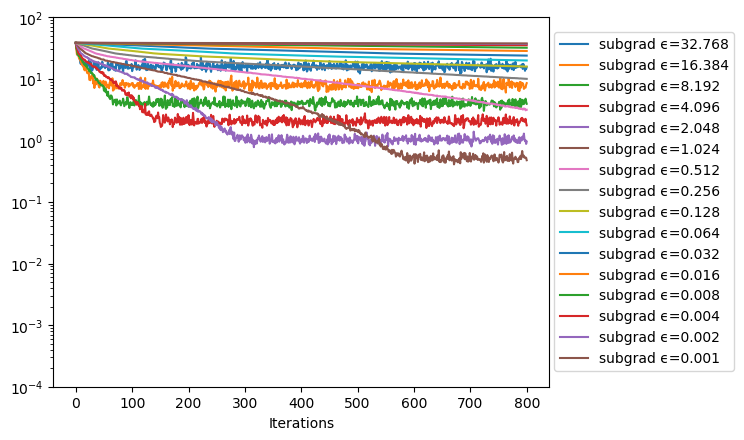

In [7]:
for j in 1:16
    k=16-j
    eps=0.001*2.0^k
    history1, final_state1 = direct_scheme(subgradientMethod, linearMax, x0, eps, 800);
    semilogy(history1, label="subgrad ϵ=$eps")
end
ylim(0.0001,100)
legend(bbox_to_anchor=[1.01,0.96],loc=2,borderaxespad=0)
xlabel("Iterations")
#ylabel("Objective Gap");
savefig("subgrad.pdf", bbox_inches="tight")

In [8]:
history2, final_state2 = synchronuous_restarting_scheme(subgradientMethod, linearMax, x0, 0.001, 800);

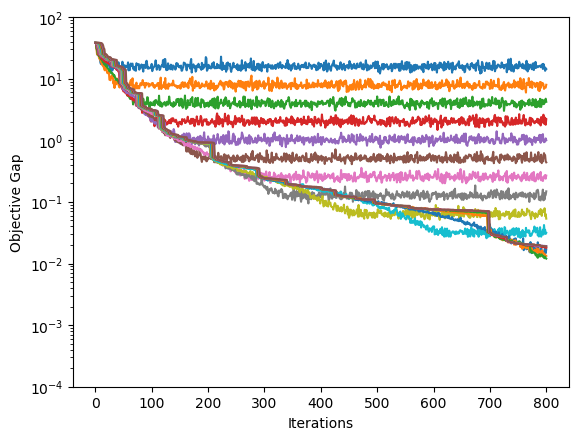

In [9]:
for j in 1:16
    k=16-j
    eps=0.001*2.0^k
    semilogy(history2[j,:], label="subgrad ϵ=$eps")
end
ylim(0.0001,100)
#legend(bbox_to_anchor=[1.01,0.96],loc=2,borderaxespad=0)
xlabel("Iterations")
ylabel("Objective Gap");
savefig("subgrad16.pdf", bbox_inches="tight")

In [10]:
history3, final_state3 = best_synchronuous_restarting_scheme(subgradientMethod, linearMax, x0, 0.001, 800);

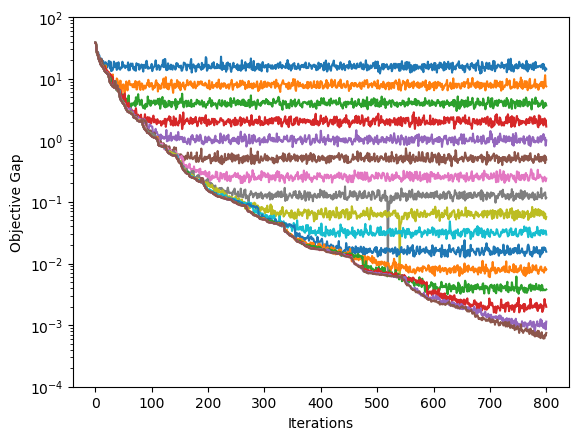

In [11]:
for j in 1:16
    k=16-j
    eps=0.001*2.0^k
    semilogy(history3[j,:], label="subgrad ϵ=$eps")
end
ylim(0.0001,100)
#legend(bbox_to_anchor=[1.01,0.96],loc=2,borderaxespad=0)
xlabel("Iterations")
ylabel("Objective Gap");
savefig("subgrad16.pdf", bbox_inches="tight")

### Nesterov's Accelerated Gradient Method ###

For smooth optimization problems, that is minimizing functions with $L$-Lipschitz continuous gradients, one can improve the convergence of the subgradient method (or gradient descent) by using *Nesterov's Accelerated Gradient Method*. Below we implement this assuming this Lipschitz constant is known.

In [12]:
@everywhere type acceleratedMethod_instance <: problem_instance
        f
        grad_f
        L::Float64
    end
@everywhere type acceleratedMethod_state <: algorithm_state
        instance::acceleratedMethod_instance
        prev_iterate
        iterate
        counter::Int64
    end

@everywhere function acceleratedMethod_initialization(inst::acceleratedMethod_instance, x0, epsilon::Float64)
        return acceleratedMethod_state(inst, x0, x0, 0)
    end
@everywhere function acceleratedMethod_iteration(state::acceleratedMethod_state)
        k = state.counter
        x1 = state.iterate
        x0 = state.prev_iterate
        y = x1 + (k-2)/(k+1)*(x1 - x0)
        g = state.instance.grad_f(y)
    
        state.prev_iterate = x1
        state.iterate = y - g/state.instance.L
        state.counter = k+1
    end

@everywhere acceleratedMethod = algorithm(acceleratedMethod_initialization, acceleratedMethod_iteration);

### A Suitable Problem for Nesterov's Accelerated Gradient Method ###

Then for any problem where we can give a gradient oracle and bound the Lipschitz constant of the gradient, we can immidiately apply the accelerated method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider solving a least squares problem plus a smooth regularizer.
$$ f(x) = \|Ax-b\|_2^2.$$
We define an instance of this simple problem as follows (setting $b=0$ so that we know the optimal objective value is zero):

In [13]:
@everywhere A = randn(200,100)
@everywhere b = A*randn(100)
@everywhere function leastSquares(x)
    0.5*norm(A*x-b)^2
end
@everywhere function grad_leastSquares(x)
    return A'*(A*x-b)
end

leastSquares_instance = acceleratedMethod_instance(leastSquares, grad_leastSquares, norm(A)^2)#eigvals(A'*A)[1000]);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this test shows the restarting scheme also provides an improvement to the convergence here.

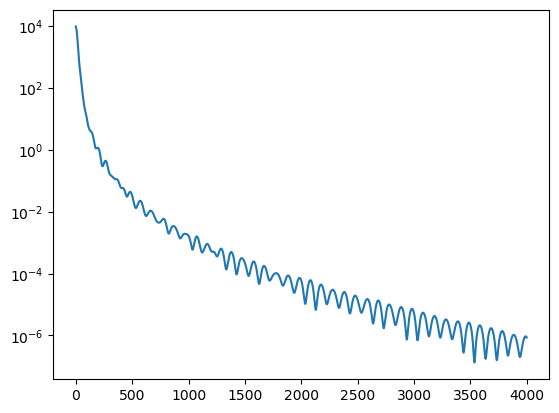

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003E811DA0>

In [14]:
history1, final_state1 = direct_scheme(acceleratedMethod, leastSquares_instance, zeros(100), 0.01, 4000);

semilogy(history1)

100020003000

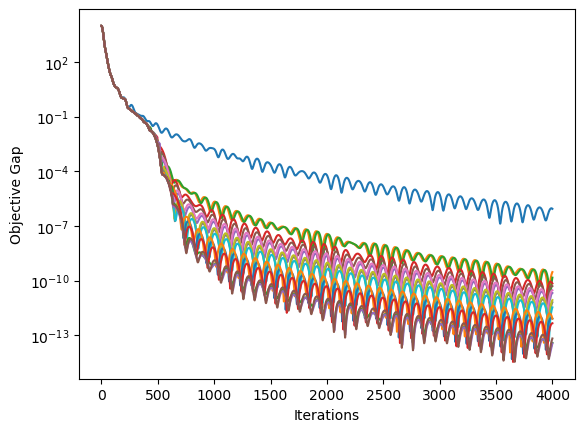

4000

In [15]:
history2, final_state2 = best_synchronuous_restarting_scheme(acceleratedMethod, leastSquares_instance, zeros(100), 0.000002, 4000);

for j in 1:16
    k=16-j
    eps=0.001*2.0^k
    semilogy(history2[j,:], label="subgrad ϵ=$eps")
end
#legend(bbox_to_anchor=[1.01,0.96],loc=2,borderaxespad=0)
xlabel("Iterations")
ylabel("Objective Gap");
savefig("subgrad16.pdf", bbox_inches="tight")

### Smoothing Method for Piecewise Linear Optimization ###

We can solve the previously considered piecewise linear optimization more efficiently using the smoothing discussed in the associated paper. This is implemented below.

In [16]:
@everywhere type smoothedMethod_instance <: problem_instance
        f
        grad_smoothf
        alpha::Float64
        beta::Float64
   end
@everywhere type smoothedMethod_state <: algorithm_state
        instance::smoothedMethod_instance
        prev_iterate
        iterate
        epsilon::Float64
        counter::Int64
    end

@everywhere function smoothedMethod_initialization(inst::smoothedMethod_instance, x0, epsilon::Float64)
        return smoothedMethod_state(inst, x0, x0, epsilon, 0)
    end
@everywhere function smoothedMethod_iteration(state::smoothedMethod_state)
        etaLocal = state.epsilon/(3.0*state.instance.beta)
        L = state.instance.alpha/etaLocal
        k = state.counter
        x1 = state.iterate
        x0 = state.prev_iterate
        y = x1 + (k-2)/(k+1)*(x1 - x0)#(k+2)/(k+1)*(x1 - x0)
        g = state.instance.grad_smoothf(y, etaLocal)
    
        state.prev_iterate = x1
        state.iterate = y - g/L
        state.counter = k+1
    end

@everywhere smoothedMethod = algorithm(smoothedMethod_initialization, smoothedMethod_iteration);

In [17]:
@everywhere n, m = 2000, 100
@everywhere A=randn(n,m)
@everywhere b=rand(Poisson(1), n)
@everywhere function value(x)
    return maximum(A*x-b)
end
@everywhere function subgrad(x)
    index = findmax(A*x-b)[2]
    return vec(A[index,:])
end

@everywhere eta = 0.01
@everywhere A2=0
@everywhere for i in 1:n
    for j in 1:m
        A2=max(A2,A[i,j]^2)
    end
 end

@everywhere function logsumexp(x) #Numerically stable version
    maxPart = value(x)
    y = (A*x-b-maxPart)/eta
    r = 0
    for i in 1:length(y)
        r = r+exp(y[i])
    end
    return maxPart+eta*log(r)
end

@everywhere function grad_logsumexp(x) #Numerically stable version
    maxPart = value(x)
    
    y = (A*x-b-maxPart)/eta
    r = 0
    for i in 1:n
       r = r+exp(y[i])
    end

    grad = zeros(m)
    for i in 1:n
        grad = grad + A[i,:]*exp(y[i])/r
    end
    return grad
end

@everywhere function grad_smoothedValue(x, eta)
    maxPart = value(x)
    y = (A*x-b-maxPart)/eta
    r = 0
    for i in 1:n
       r = r+exp(y[i])
    end
    grad = zeros(m)
    for i in 1:n
        grad = grad + A[i,:]*exp(y[i])/r
    end
    return grad
end

smoothed_instance = smoothedMethod_instance(value, grad_smoothedValue, A2, log(n));

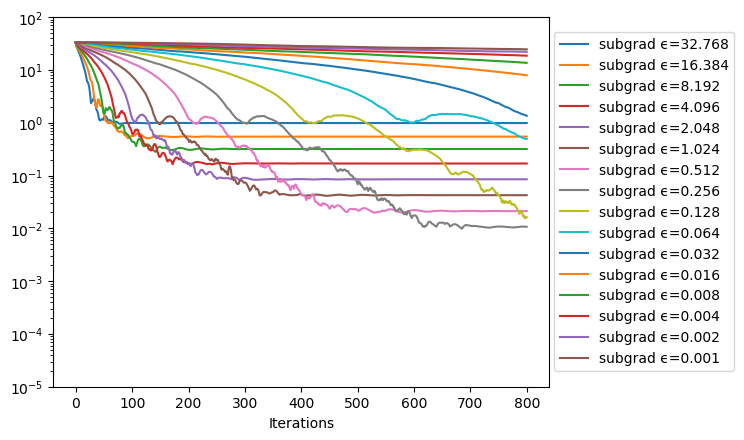

PyObject Text(0.5, 24.0, 'Iterations')

In [18]:
for j in 1:16
    k=16-j
    eps=0.001*2.0^k
    history1, final_state1 = direct_scheme(smoothedMethod, smoothed_instance, x0, eps, 800)
    semilogy(history1, label="subgrad ϵ=$eps")
end
ylim(0.00001,100)
legend(bbox_to_anchor=[1.01,0.96],loc=2,borderaxespad=0)
xlabel("Iterations")

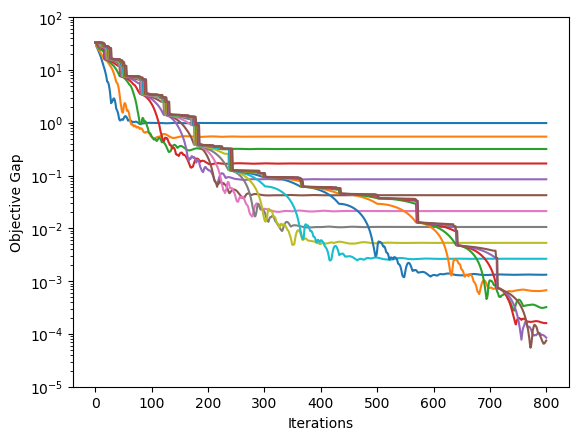

In [19]:
smooth_history2, final_state2 = synchronuous_restarting_scheme(smoothedMethod, smoothed_instance, x0, 0.001, 800)

for j in 1:16
    k= 16-j
    semilogy(smooth_history2[j,:], label="accel $k")
end

ylim(0.00001,100)
xlabel("Iterations")
ylabel("Objective Gap");

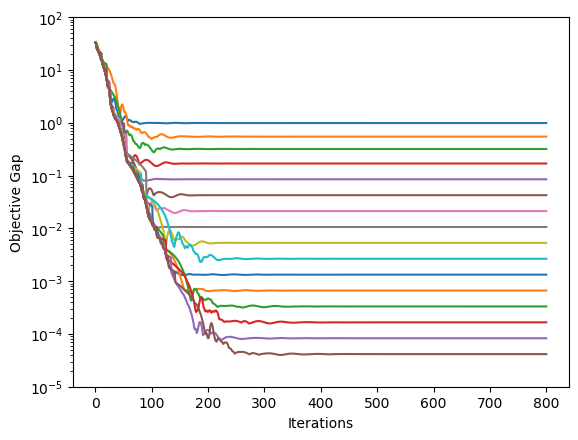

In [20]:
smooth_history3, final_state3 = best_synchronuous_restarting_scheme(smoothedMethod, smoothed_instance, x0, 0.001, 800)

for j in 1:16
    k= 16-j
    semilogy(smooth_history3[j,:], label="accel $k")
end

ylim(0.00001,100)
xlabel("Iterations")
ylabel("Objective Gap");

# Implementation of Parallel Asynchronous Scheme #

Importantly, the restarting scheme leveraged by this paper can be easily parallelized. Each of the $log(1/\epsilon)$ copies of the algorithm can be run by separate processes. This parallelization does not require any synchonization since they only need to pass messages forward to the following process. Thus an asynchronous parallel version follows without much modification from the sequential version previously given.

In [21]:
#"Defining iteration what first thread will be assigned to do. Improvements in objective are sent to second thread"
@everywhere function first_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64,
                output::RemoteChannel{Channel{Tuple}})
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    obj = inst.f(x0) - epsilon
    
    #Do T total iterations of the algorithm
    for i in 1:T
        #Do an iteration
        alg.iteration(state)
        value = inst.f(state.iterate)
        ret[i+1] = min(ret[i], value)
        
        #Check if current iterate complete current goal, if so pass it forward
        if value < obj
            obj = value - epsilon
            put!(output, (state.iterate, value))
        end
    end
    return ret, state.iterate #Return array of function values seen and final iterate
end

#"Defining iteration what middle group of threads will be assigned to do. Receives updates from precessesor and sends improvements to successor"
@everywhere function middle_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                input::RemoteChannel{Channel{Tuple}}, output::RemoteChannel{Channel{Tuple}})
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    obj = inst.f(x0) - epsilon
    
    #Do T total iterations of the algorithm
    for i in 1:T
        #Do an iteration
        alg.iteration(state)
        x, value = state.iterate, inst.f(state.iterate)
        ret[i+1] = min(ret[i], value)
        
        #Read mailbox looking for anything completing the current goal
        while isready(input)
            y, v = take!(input)
            if v<obj
                x, value = y,v
            end
        end
        
        #Check if we completed the current goal, if so restart and pass it forward
        if value < obj
            obj = value - epsilon
            state = alg.initialization(inst, x, epsilon)
            put!(output, (x, value))
        end
    end 
    return ret, state.iterate #Return array of function values seen and final iterate
end

#"Defining iteration what last thread will be assigned to do. Receives updates from second to last thread."
@everywhere function last_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                input::RemoteChannel{Channel{Tuple}})
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    obj = inst.f(x0) - epsilon
    
    #Do T total iterations of the algorithm
    for i in 1:T
        #Do an iteration
        alg.iteration(state)
        x, value = state.iterate, inst.f(state.iterate)
        ret[i+1] = min(ret[i], value)

        #Read mailbox looking for anything completing the current goal
        while isready(input)
            y, v = take!(input)
            if v<obj
                x, value = y,v
            end
        end
        
        #Check if we completed the current goal, if so restart
        if value < obj
           obj = value - epsilon
           state = alg.initialization(inst, x, epsilon)
        end
    end
    return ret, state.iterate #Return array of function values seen and final iterate
end

#"Asynchronuous restarting scheme first-order methods that runs log(1/eps) versions of the algorithm in parallel, computing progress intelligently between them"
function asynchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)    
    N = min(16, max(2,ceil(Int64, -1*log(2,epsilon))))   #Compute how many processes to use, must be between 2 and 16
    
    #Defining communication channels for each process to send its progress to the subsequent process
    inputs = Array{RemoteChannel{Channel{Tuple}}}(N-1)
    for j in 1:(N-1)
        inputs[j] = RemoteChannel(()->Channel{Tuple}(32));
    end
    
    #Assigning each thread its task
    futures = Array{Future}(N)
    for j in 1:N
        p = processes[j]
        if j==1
            #Launch first process
            futures[j] = remotecall(first_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j])
        elseif j<N
            #Launch middle processes
            futures[j] = remotecall(middle_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j-1], inputs[j])
        else
            #Launch last process
            futures[j] = remotecall(last_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j-1])
        end
    end

    #Retrieve answers from each thread, getting the array of function values seen and final iterate
    ret = Array{Array{Float64}}(N)
    x = Array{Array{Float64}}(N)
    for j in 1:N
        ret[j], x[j] = fetch(futures[j])
    end
    return ret, x #Return double array of function values seen by each process and final iterates
end;